### Result Analysis

Mean Accuracy, Precision, Recall, F1-score (from cross-validation)
Test set metrics for generalization ability
ROC Curve with AUC for each class
Total training time

Mean Accuracy: 0.8596
Mean Precision: 0.8627
Mean Recall: 0.8596
Mean F1 Score: 0.8592
Training Time: 1.83 seconds

Test Metrics:
Accuracy: 0.8385
Precision: 0.8422
Recall: 0.8385
F1 Score: 0.8382


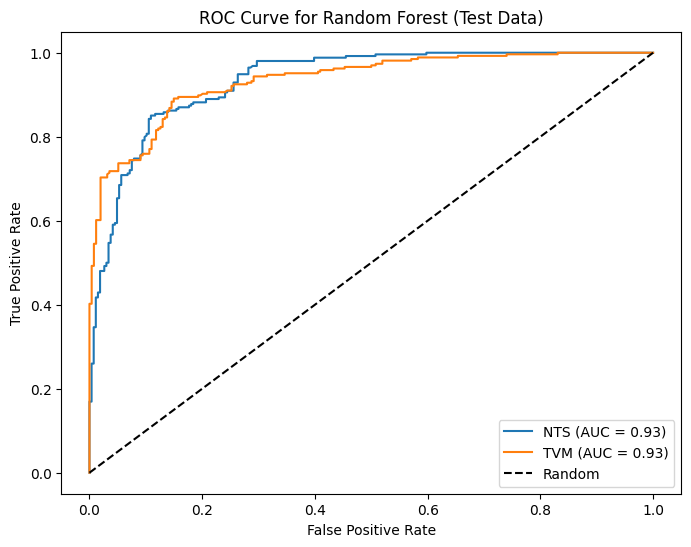

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import time

# Load training data
train_file_path = '../Dataset/train_18f.csv'  # Update with the path to your training data
train_data = pd.read_csv(train_file_path)

# Load testing data
test_file_path = '../Dataset/test_18f.csv'  # Update with the path to your test data
test_data = pd.read_csv(test_file_path)


# Labels to drop from 'Class' column [sample]
# labels_to_drop = [NTS','TVM', 'TWM', 'WSK', 'TSK', 'NTSwL','TVMwL','TWMwL','WSKwL','TSKwL']  # Add the labels you want to drop
# Without Labels to drop
# labels_to_drop = []
# Binary classification test[NTS-Sniff, NTSwL-Sniff with Load]
labels_to_drop = ['TWM','WSK','TSK','NTSwL','TVMwL','TWMwL','WSKwL','TSKwL']  # Add the labels you want to drop

# Drop rows with specified labels from 'Class' column
train_data = train_data[~train_data['Class'].isin(labels_to_drop)]
test_data = test_data[~test_data['Class'].isin(labels_to_drop)]

# Reset index if needed
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Drop List for 18 features
# features_to_drop = ['Class']
# Drop List for 7 features
# features_to_drop = ['Class', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4', 'Load_1min', 'Load_5min', 'Load_15min', 'Ping_Time(ms)', 'Ping_Min(ms)', 'Ping_Max(ms)', 'Ping_PacketLoss']
# Drop List for only ping feature
features_to_drop = ['Class', 'CPU_Total', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4', 'Disk_wrVolume', 'Disk_wraccessVolume', 'Load_1min', 'Load_5min', 'Load_15min', 'Mem_Avail', 'Mem_freeTotal', 'Traffic_inVolume', 'Traffic_outVolume']

# Assume your target variable is named 'Class' and features are other columns
X_train = train_data.drop(features_to_drop, axis=1)
y_train = train_data['Class']
X_test = test_data.drop(features_to_drop, axis=1)
y_test = test_data['Class']

# If the 'Class' column contains categorical labels, encode them using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth = 7, random_state=42)


# Perform 10-fold cross-validation on the training data
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Record the start time
start_time = time.time()

for train_index, val_index in stratified_kfold.split(X_train, y_train_encoded):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Train the model on the training fold
    random_forest_model.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_val_pred = random_forest_model.predict(X_val_fold)

    # Evaluate the model on the validation fold
    accuracy_list.append(accuracy_score(y_val_fold, y_val_pred))
    precision_list.append(precision_score(y_val_fold, y_val_pred, average='weighted'))
    recall_list.append(recall_score(y_val_fold, y_val_pred, average='weighted'))
    f1_list.append(f1_score(y_val_fold, y_val_pred, average='weighted'))

# Record the end time
end_time = time.time()

# Calculate mean metrics over all folds
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_precision = sum(precision_list) / len(precision_list)
mean_recall = sum(recall_list) / len(recall_list)
mean_f1 = sum(f1_list) / len(f1_list)

# Print mean metrics
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Train the model on the entire training data
random_forest_model.fit(X_train, y_train_encoded)

# Predict on the test data
y_test_pred = random_forest_model.predict(X_test)

# Evaluate the model on the test data
accuracy_test = accuracy_score(y_test_encoded, y_test_pred)
precision_test = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_test = recall_score(y_test_encoded, y_test_pred, average='weighted')
f1_test = f1_score(y_test_encoded, y_test_pred, average='weighted')

# Print test metrics
print("\nTest Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")

# Plot ROC Curve and Calculate AUC for the test data
n_classes = len(label_encoder.classes_)
y_test_proba = random_forest_model.predict_proba(X_test)

# One-hot encode the true labels
y_test_one_hot = pd.get_dummies(y_test_encoded, columns=label_encoder.classes_)

# Assuming y_test contains the true class labels
unique_classes = y_test.unique()

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_one_hot.iloc[:, i], y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{unique_classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest (Test Data)')
plt.legend(loc='lower right')
plt.show()

Mean cross-validation accuracy, precision, recall, F1
Test performance metrics
Confusion matrix visualization
Training duration

Mean Accuracy: 0.9998
Mean Precision: 0.9998
Mean Recall: 0.9998
Mean F1 Score: 0.9998
Training Time: 6.15 seconds

Test Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


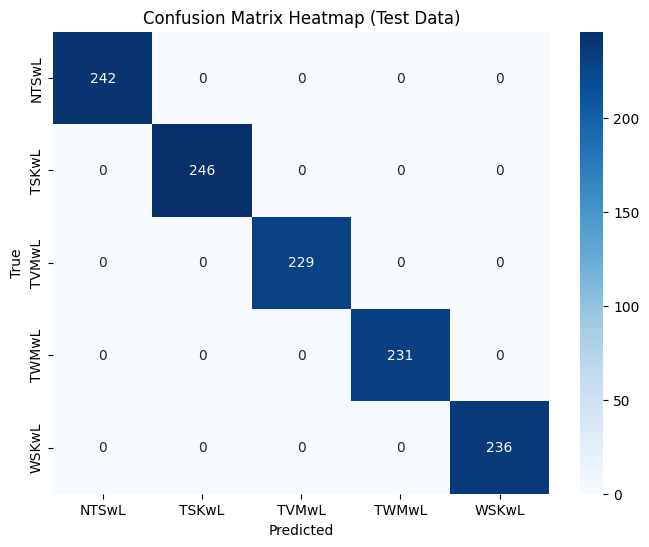

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import time

# Load training data
train_file_path = '../Dataset/train_18f.csv'  # Update with the path to your training data
train_data = pd.read_csv(train_file_path)

# Load testing data
test_file_path = '../Dataset/extra_18f.csv'  # Update with the path to your test data
test_data = pd.read_csv(test_file_path)


# Labels to drop from 'Class' column [sample]
# labels_to_drop = [NTS','TVM', 'TWM', 'WSK', 'TSK', 'NTSwL','TVMwL','TWMwL','WSKwL','TSKwL']  # Add the labels you want to drop
# Without Labels to drop
# labels_to_drop = []
# Binary classification test[NTS-Sniff, NTSwL-Sniff with Load]
# labels_to_drop = ['NTSwL','TVMwL','TWMwL','WSKwL','TSKwL']  # Add the labels you want to drop
labels_to_drop = ['NTS','TVM','TWM','WSK','TSK']  # Add the labels you want to drop

# Drop rows with specified labels from 'Class' column
train_data = train_data[~train_data['Class'].isin(labels_to_drop)]
test_data = test_data[~test_data['Class'].isin(labels_to_drop)]

# Reset index if needed
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Drop List for 18 features
features_to_drop = ['Class']
# Drop List for 7 features
# features_to_drop = ['Class', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4', 'Load_1min', 'Load_5min', 'Load_15min', 'Ping_Time(ms)', 'Ping_Min(ms)', 'Ping_Max(ms)', 'Ping_PacketLoss']
# Drop List for only ping feature
# features_to_drop = ['Class', 'CPU_Total', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4', 'Disk_wrVolume', 'Disk_wraccessVolume', 'Load_1min', 'Load_5min', 'Load_15min', 'Mem_Avail', 'Mem_freeTotal', 'Traffic_inVolume', 'Traffic_outVolume']

# Assume your target variable is named 'Class' and features are other columns
X_train = train_data.drop(features_to_drop, axis=1)
y_train = train_data['Class']
X_test = test_data.drop(features_to_drop, axis=1)
y_test = test_data['Class']

# If the 'Class' column contains categorical labels, encode them using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth = 7, random_state=42)


# Perform 10-fold cross-validation on the training data
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Record the start time
start_time = time.time()

for train_index, val_index in stratified_kfold.split(X_train, y_train_encoded):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Train the model on the training fold
    random_forest_model.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_val_pred = random_forest_model.predict(X_val_fold)

    # Evaluate the model on the validation fold
    accuracy_list.append(accuracy_score(y_val_fold, y_val_pred))
    precision_list.append(precision_score(y_val_fold, y_val_pred, average='weighted'))
    recall_list.append(recall_score(y_val_fold, y_val_pred, average='weighted'))
    f1_list.append(f1_score(y_val_fold, y_val_pred, average='weighted'))

# Record the end time
end_time = time.time()

# Calculate mean metrics over all folds
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_precision = sum(precision_list) / len(precision_list)
mean_recall = sum(recall_list) / len(recall_list)
mean_f1 = sum(f1_list) / len(f1_list)

# Print mean metrics
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Train the model on the entire training data
random_forest_model.fit(X_train, y_train_encoded)

# Predict on the test data
y_test_pred = random_forest_model.predict(X_test)

# Evaluate the model on the test data
accuracy_test = accuracy_score(y_test_encoded, y_test_pred)
precision_test = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_test = recall_score(y_test_encoded, y_test_pred, average='weighted')
f1_test = f1_score(y_test_encoded, y_test_pred, average='weighted')

# Print test metrics
print("\nTest Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")

# Plot Confusion Matrix Heatmap for the test data
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap (Test Data)')
plt.show()


The code compares multiple ML models (Decision Tree, Random Forest, XGBoost, LightGBM) to evaluate how accurately IoT sniffing behavior can be detected using only ping-based RTT features across different binary class scenarios.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
print("Keeping only the ping factors to check how rtt based detection works ")

train_data = pd.read_csv('../Dataset/train_18f.csv')
test_data = pd.read_csv('../Dataset/test_18f.csv')


features_to_drop = ['Class', 'CPU_Total', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4',
                    'Disk_wrVolume', 'Disk_wraccessVolume', 'Load_1min', 'Load_5min',
                    'Load_15min', 'Mem_Avail', 'Mem_freeTotal', 'Traffic_inVolume',
                    'Traffic_outVolume']


class_pairs = [
    ('NTS', 'TVM'),
    ('NTS', 'WSK'),
    ('NTSwL', 'TVMwL'),
    ('NTSwL', 'WSKwL')
]

# Models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=7, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42),
    'XGBoost': XGBClassifier(max_depth=7, random_state=42),
    'LightGBM': LGBMClassifier(verbose=-1, max_depth=7, random_state=42)
}

# Run evaluations
for label1, label2 in class_pairs:
    print(f"\n{label1} - {label2}")
    
    train_subset = train_data[train_data['Class'].isin([label1, label2])]
    test_subset = test_data[test_data['Class'].isin([label1, label2])]

    X_train = train_subset.drop(features_to_drop, axis=1)
    y_train = train_subset['Class']
    X_test = test_subset.drop(features_to_drop, axis=1)
    y_test = test_subset['Class']

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    for model_name, model in models.items():
        model.fit(X_train, y_train_encoded)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test_encoded, y_pred) * 100
        print(f"{model_name} Accuracy: {acc:.2f}%")

Keeping only the ping factors to check how rtt based detection works 

NTS - TVM
Decision Tree Accuracy: 84.23%
Random Forest Accuracy: 83.85%
XGBoost Accuracy: 86.35%
LightGBM Accuracy: 86.15%

NTS - WSK
Decision Tree Accuracy: 64.85%
Random Forest Accuracy: 66.53%
XGBoost Accuracy: 61.72%
LightGBM Accuracy: 67.15%

NTSwL - TVMwL
Decision Tree Accuracy: 63.91%
Random Forest Accuracy: 66.88%
XGBoost Accuracy: 65.82%
LightGBM Accuracy: 64.76%

NTSwL - WSKwL
Decision Tree Accuracy: 67.99%
Random Forest Accuracy: 68.62%
XGBoost Accuracy: 66.32%
LightGBM Accuracy: 67.57%


This code evaluates a Random Forest model using ping-based features only, across four different class-pair combinations, and plots four ROC curves (AUC-based performance) to compare sniffing behavior detection under various label exclusion scenarios.

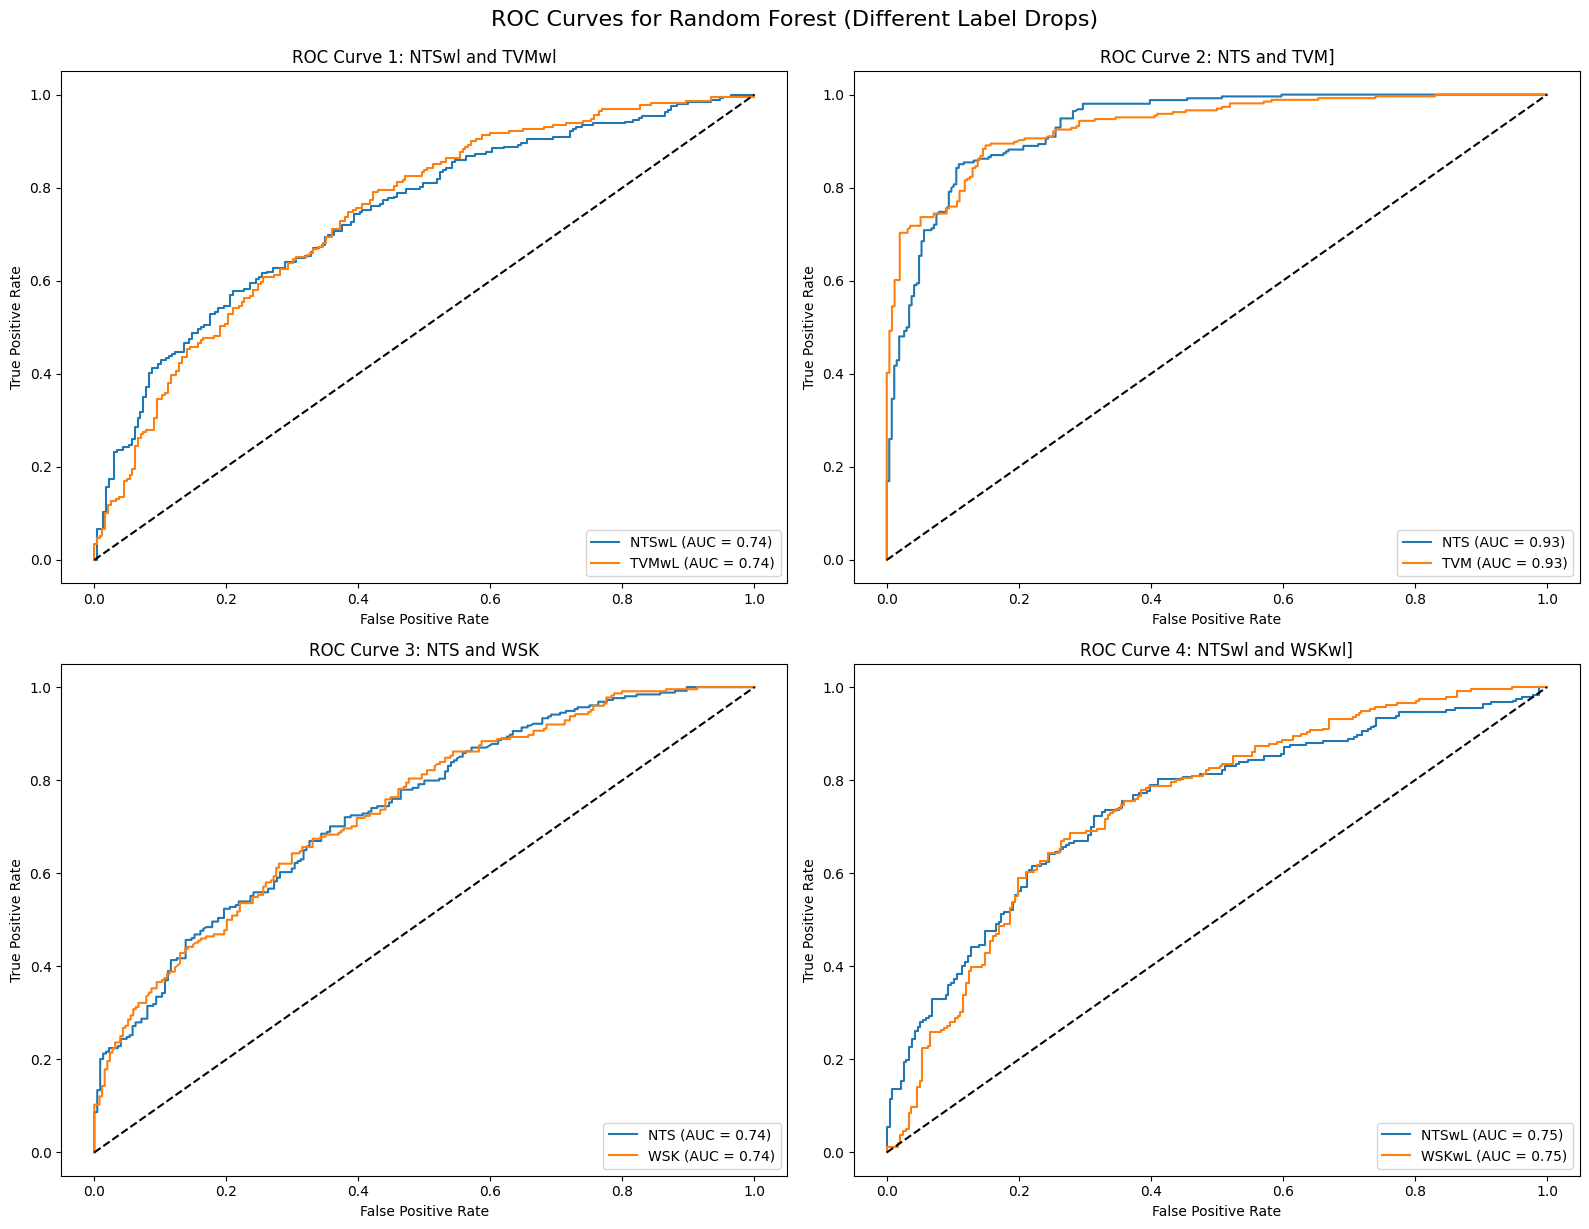

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder


label_drop_sets = [
    ['TVM','NTS','TWM','WSK','TSK','TWMwL','WSKwL','TSKwL'],
    ['NTSwL','TVMwL','TWM','WSK','TSK','TWMwL','WSKwL','TSKwL'],
    ['TVM','NTSwL','TVMwL','TWM','TSK','TWMwL','WSKwL','TSKwL'],
    ['WSK','NTS','TVM','TVMwL','TWM','TSK','TWMwL','TSKwL']
]


titles = [
    "ROC Curve 1: NTSwl and TVMwl",
    "ROC Curve 2: NTS and TVM]",
    "ROC Curve 3: NTS and WSK",
    "ROC Curve 4: NTSwl and WSKwl]"
]


features_to_drop = ['Class', 'CPU_Total', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4',
                    'Disk_wrVolume', 'Disk_wraccessVolume', 'Load_1min', 'Load_5min',
                    'Load_15min', 'Mem_Avail', 'Mem_freeTotal', 'Traffic_inVolume',
                    'Traffic_outVolume']


train_data = pd.read_csv('../Dataset/train_18f.csv')
test_data = pd.read_csv('../Dataset/test_18f.csv')


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, labels_to_drop in enumerate(label_drop_sets):
    # Drop specified labels
    train_filtered = train_data[~train_data['Class'].isin(labels_to_drop)].copy()
    test_filtered = test_data[~test_data['Class'].isin(labels_to_drop)].copy()

   
    X_train = train_filtered.drop(features_to_drop, axis=1)
    y_train = train_filtered['Class']
    X_test = test_filtered.drop(features_to_drop, axis=1)
    y_test = test_filtered['Class']

   
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    unique_classes = y_test.unique()

    
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
    rf_model.fit(X_train, y_train_encoded)

    
    y_test_proba = rf_model.predict_proba(X_test)

    # One-hot encode true labels
    y_test_one_hot = pd.get_dummies(y_test_encoded, columns=label_encoder.classes_)

    # Plot ROC for each class
    ax = axes[idx]
    n_classes = len(label_encoder.classes_)

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_one_hot.iloc[:, i], y_test_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{unique_classes[i]} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(titles[idx])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.suptitle("ROC Curves for Random Forest (Different Label Drops)", fontsize=16, y=1.02)
plt.show()


This code trains a Random Forest Classifier using selected system features (excluding ping metrics) to detect sniffing-related behavior in IoT devices, tests it on unseen data (extra_18f.csv), and visualizes its classification performance using a confusion matrix heatmap.

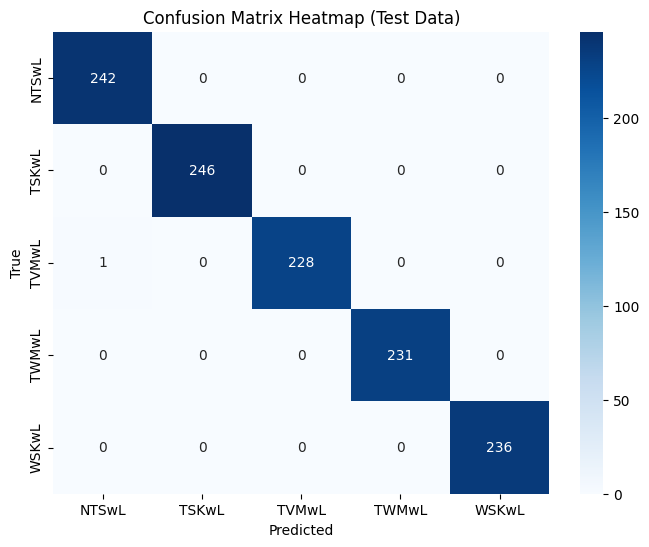

In [7]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import time


train_file_path = '../Dataset/train_18f.csv' 
train_data = pd.read_csv(train_file_path)


test_file_path = '../Dataset/extra_18f.csv'  
test_data = pd.read_csv(test_file_path)

labels_to_drop = ['NTS','TVM','TWM','WSK','TSK']  # Add the labels you want to drop

# Drop rows with specified labels from 'Class' column
train_data = train_data[~train_data['Class'].isin(labels_to_drop)]
test_data = test_data[~test_data['Class'].isin(labels_to_drop)]

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


features_to_drop = ['Class', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4', 'Load_1min', 'Load_5min', 'Load_15min', 'Ping_Time(ms)', 'Ping_Min(ms)', 'Ping_Max(ms)', 'Ping_PacketLoss']

# target variable is named 'Class'
X_train = train_data.drop(features_to_drop, axis=1)
y_train = train_data['Class']
X_test = test_data.drop(features_to_drop, axis=1)
y_test = test_data['Class']

#'Class' column contains categorical labels, encode them using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


random_forest_model = RandomForestClassifier(n_estimators=100, max_depth = 7, random_state=42)


random_forest_model.fit(X_train, y_train_encoded)

y_test_pred = random_forest_model.predict(X_test)

# Plot Confusion Matrix Heatmap for the test data
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap (Test Data)')
plt.show()



This code trains a Random Forest model using system resource features (CPU, memory, disk, traffic) — excluding ping metrics — to detect IoT sniffing behavior and visualizes its classification performance using a confusion matrix heatmap on unseen data.

This code trains a Random Forest model on non-ping, resource-level features to detect non-load sniffing behaviors in IoT devices and visualizes its classification performance through a confusion matrix heatmap on unseen data.

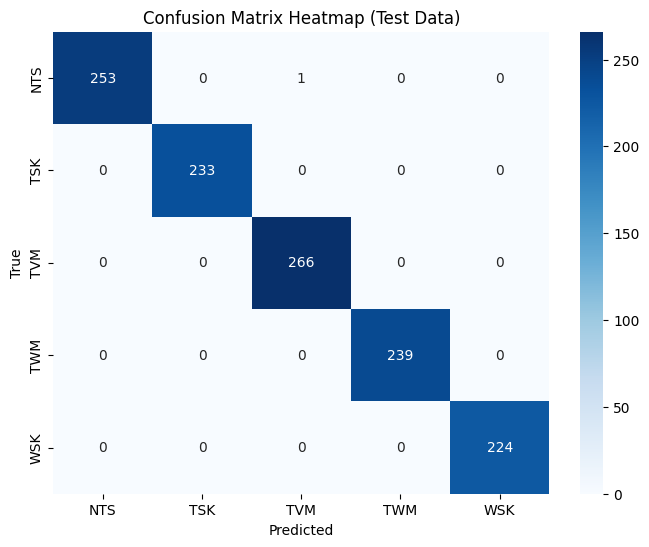

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import time

train_file_path = '../Dataset/train_18f.csv'  # Update with the path to your training data
train_data = pd.read_csv(train_file_path)

test_file_path = '../Dataset/extra_18f.csv'  # Update with the path to your test data
test_data = pd.read_csv(test_file_path)

labels_to_drop = ['NTSwL','TVMwL','TWMwL','WSKwL','TSKwL']  # Add the labels you want to drop

train_data = train_data[~train_data['Class'].isin(labels_to_drop)]
test_data = test_data[~test_data['Class'].isin(labels_to_drop)]

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

features_to_drop = ['Class', 'CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4', 'Load_1min', 'Load_5min', 'Load_15min', 'Ping_Time(ms)', 'Ping_Min(ms)', 'Ping_Max(ms)', 'Ping_PacketLoss']

X_train = train_data.drop(features_to_drop, axis=1)
y_train = train_data['Class']
X_test = test_data.drop(features_to_drop, axis=1)
y_test = test_data['Class']

# 'Class' column contains categorical labels, encode them using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth = 7, random_state=42)

# Train the model on the entire training data
random_forest_model.fit(X_train, y_train_encoded)

# Predict on the test data
y_test_pred = random_forest_model.predict(X_test)

# Plot Confusion Matrix Heatmap for the test data
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap (Test Data)')
plt.show()

This script loads a pre-trained Random Forest model and label encoder, takes a single manual input of IoT system metrics, and predicts the corresponding sniffing behavior class.

In [14]:
import pandas as pd
import joblib

# Loading the model
model = joblib.load('../Models/rf_model.pkl')
label_encoder = joblib.load('../Models/label_encoder_rf.pkl')

# Input feature names
feature_names = ['CPU_Total', 'Disk_wrVolume', 'Disk_wraccessVolume', 
                 'Mem_Avail', 'Mem_freeTotal', 'Traffic_inVolume', 'Traffic_outVolume']

# Manual input values
manual_input = pd.DataFrame(
    [[5, 5558714.089, 35.7965, 1092102144, 7852256597, 2811331.436, 769637.7216]],
    columns=feature_names
)

pred_encoded = model.predict(manual_input)
pred_decoded = label_encoder.inverse_transform(pred_encoded)

# Output result
print(f"\n Predicted Class for the entered input: {pred_decoded[0]}")



 Predicted Class for the entered input: TWMwL


This script loads a saved LightGBM (or any ML) model and its encoder, predicts IoT sniffing behavior on test data, compares with actual labels to calculate accuracy, and saves the full results to predictions.csv.

In [19]:
import pandas as pd
import joblib

# Load the saved model and label encoder
model = joblib.load('../Models/lgb_model.pkl')  # Change to xgb_model.pkl, rf_model.pkl, etc. if needed
label_encoder = joblib.load('../Models/label_encoder_lgb.pkl')

# File path
test_file_path = '../Dataset/test_18f.csv'

# Read CSV file
new_data = pd.read_csv(test_file_path)

# Drop unused features (same as during training)
features_to_drop1 = ['CPU_P1', 'CPU_P2', 'CPU_P3', 'CPU_P4',
                     'Load_1min', 'Load_5min', 'Load_15min',
                     'Ping_Time(ms)', 'Ping_Min(ms)', 'Ping_Max(ms)', 'Ping_PacketLoss']

# Keep relevant features + target class
features_used = new_data.drop(columns=features_to_drop1)

# Separate features for prediction (exclude 'Class')
features_only = features_used.drop(columns=['Class'])

# Predict using the loaded model
predictions_encoded = model.predict(features_only)

# Decode predictions
predictions_decoded = label_encoder.inverse_transform(predictions_encoded)

# Append predictions to the dataframe
features_used['Predicted_Class'] = predictions_decoded

# Show results
print("\nPredictions for the new input data:")
print(features_used[['Class', 'Predicted_Class']])

# Save predictions to CSV
output_csv_path = '../Predictions/predictions_lgb.csv'
features_used.to_csv(output_csv_path, index=False)
print(f"\n Predictions saved to: {output_csv_path}")
from sklearn.metrics import accuracy_score

# Calculate accuracy
true_labels = features_used['Class']
predicted_labels = features_used['Predicted_Class']

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\n🎯 Prediction Accuracy: {accuracy * 100:.2f}%")


Predictions for the new input data:
      Class Predicted_Class
0     NTSwL           NTSwL
1     TWMwL           TWMwL
2       NTS             NTS
3     WSKwL           WSKwL
4     TVMwL           TVMwL
...     ...             ...
2395    TVM             TVM
2396    TSK             TSK
2397  TWMwL           TWMwL
2398  NTSwL           NTSwL
2399    NTS             NTS

[2400 rows x 2 columns]

 Predictions saved to: ../Predictions/predictions_lgb.csv

🎯 Prediction Accuracy: 99.79%
